In [36]:
#import pandas_datareader as webreader # Remote data access for pandas
import math # Mathematical functions 
import numpy as np # Fundamental package for scientific computing with Python
import pandas as pd # Additional functions for analysing and manipulating data
from datetime import date, timedelta, datetime # Date Functions
from pandas.plotting import register_matplotlib_converters # This function adds plotting functions for calender dates
import matplotlib.pyplot as plt # Important package for visualization - we use this to plot the market data
import matplotlib.dates as mdates # Formatting dates
from sklearn.metrics import mean_absolute_error, mean_squared_error # Packages for measuring model performance / errors
from keras.models import Sequential # Deep learning library, used for neural networks
from keras.layers import LSTM, Dense, Dropout # Deep learning classes for recurrent and regular densely-connected layers
from keras.callbacks import EarlyStopping # EarlyStopping during model training
from sklearn.preprocessing import RobustScaler, MinMaxScaler # This Scaler removes the median and scales the data according to the quantile range to normalize the price data 
import seaborn as sns

In [37]:
pip install python-binance

In [38]:
from datetime import datetime
from pandas_datareader.data import DataReader

In [39]:
# Data retrieval for cryptocurrencies BTCUSDT ETHUSDT XMRUSDT 
# Binance API credentials 
apikey = '2ZaEiNukiFtPHqnYdCGMANNimHdcCF0nvv4L9eYXMIdr4ovveQrca4NWKsZ7DxAy'
secretkey = '9zjousoyG0t2wblcGkm0tVGLBfz6Woo3paakGh49Vhj0IxrGGXl332b1KQaxlJKY'

from binance import Client, ThreadedWebsocketManager, ThreadedDepthCacheManager
#API Initialization 
client = Client(apikey, secretkey)

In [40]:
#Data collection: BTCUSDT 
#The idea is to focus on smaller time frames, specifically since the last crypto crash, mid-May 2021, to eliminate this skewing event

klines = client.get_historical_klines("BTCUSDT", Client.KLINE_INTERVAL_3MINUTE, "1 Jun, 2021", "1 Dec, 2021")

# for candle in klines:
#   print(candle)

hist_df = pd.DataFrame(klines)
hist_df.columns = (['Open Time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close Time', 'Quote Asset Volume','Nb of Trade', 'TakerBuyBaseVolume', 'TakerBuyQuoteVolume','Ignored'])
# hist_df.drop(labels = ['TakerBuyBaseVolume', 'TakerBuyQuoteVolume', 'Ignored', 'Quote Asset Volume'], inplace = True,axis = 1)
# hist_df['Close Time'] = pd.to_datetime(hist_df['Close Time']/1000, unit='s')
# hist_df['Open Time'] = pd.to_datetime(hist_df['Open Time']/1000, unit='s')
hist_df.drop(['Ignored', 'TakerBuyBaseVolume', 'TakerBuyQuoteVolume', 'Quote Asset Volume'], inplace= True, axis = 1)
# hist_df['Open Time'] = hist_df.index

hist_df = hist_df.reset_index().set_index('Open Time', drop=False)
hist_df.index.name = None
df = hist_df

df.to_csv('BTCUSDT_3MIN_Jun2021_DEC2021')
df

,index,Open Time,Open,High,Low,Close,Volume,Close Time,Nb of Trade
1622505600000,0,1622505600000,37253.82000000,37456.17000000,37100.00000000,37451.49000000,337.16321300,1622505779999,8759
1622505780000,1,1622505780000,37451.48000000,37665.56000000,37424.07000000,37624.56000000,1007.53698600,1622505959999,16211
1622505960000,2,1622505960000,37624.56000000,37631.62000000,37502.59000000,37595.74000000,184.45904200,1622506139999,6391
1622506140000,3,1622506140000,37595.74000000,37649.04000000,37528.74000000,37591.40000000,175.46544300,1622506319999,5286
1622506320000,4,1622506320000,37586.55000000,37590.00000000,37520.01000000,37531.12000000,172.63326900,1622506499999,4728
...,...,...,...,...,...,...,...,...,...
1638316080000,87706,1638316080000,56963.07000000,56989.16000000,56839.74000000,56843.19000000,121.60075000,1638316259999,3237
1638316260000,87707,1638316260000,56850.01000000,57053.90000000,56762.39000000,57046.04000000,171.24335000,1638316439999,4405
1638316440000,87708,1638316440000,57046.05000000,57054.09000000,56967.15000000,57000.01000000,57.74293000,1638316619999,1645
1638316620000,87709,1638316620000,57000.01000000,57012.20000000,56835.92000000,56950.56000000,55.53555000,1638316799999,1864


In [41]:
# Indexing Batches
df_train = df.sort_values(by=['Open Time']).copy()

# Saving a copy of the dates index, before we need to reset it to numbers
date_index = df_train.index

# We reset the index, so we can convert the date-index to a number-index
df_train = df_train.reset_index(drop=True).copy()
df_train.drop(columns=['index'], inplace=True, axis = 1)
df_train.tail(5)

,Open Time,Open,High,Low,Close,Volume,Close Time,Nb of Trade
87706,1638316080000,56963.07000000,56989.16000000,56839.74000000,56843.19000000,121.60075000,1638316259999,3237
87707,1638316260000,56850.01000000,57053.90000000,56762.39000000,57046.04000000,171.24335000,1638316439999,4405
87708,1638316440000,57046.05000000,57054.09000000,56967.15000000,57000.01000000,57.74293000,1638316619999,1645
87709,1638316620000,57000.01000000,57012.20000000,56835.92000000,56950.56000000,55.53555000,1638316799999,1864
87710,1638316800000,56950.56000000,57011.08000000,56650.00000000,56667.73000000,218.73433000,1638316979999,5330


In [42]:
def prepare_data(df):

    # List of considered Features
    FEATURES = ['Open', 'High', 'Low', 'Close', 'Volume']

    print('FEATURE LIST')
    print([f for f in FEATURES])

    # Create the dataset with features and filter the data to the list of FEATURES
    df_filter = df[FEATURES]
    
    # Convert the data to numpy values
    np_filter_unscaled = np.array(df_filter)
    #np_filter_unscaled = np.reshape(np_unscaled, (df_filter.shape[0], -1))
    print(np_filter_unscaled.shape)

    np_c_unscaled = np.array(df['Close']).reshape(-1, 1)
    
    return np_filter_unscaled, np_c_unscaled
    
np_filter_unscaled, np_c_unscaled = prepare_data(df_train)
                                          
# Creating a separate scaler that works on a single column for scaling predictions
# Scale each feature to a range between 0 and 1
scaler_train = MinMaxScaler()
np_scaled = scaler_train.fit_transform(np_filter_unscaled)
    
# Create a separate scaler for a single column
scaler_pred = MinMaxScaler()
np_scaled_c = scaler_pred.fit_transform(np_c_unscaled)   

FEATURE LIST
['Open', 'High', 'Low', 'Close', 'Volume']
(87711, 5)


(70109, 50, 5) (70109, 10)
(17532, 50, 5) (17532, 10)


<function matplotlib.pyplot.show>

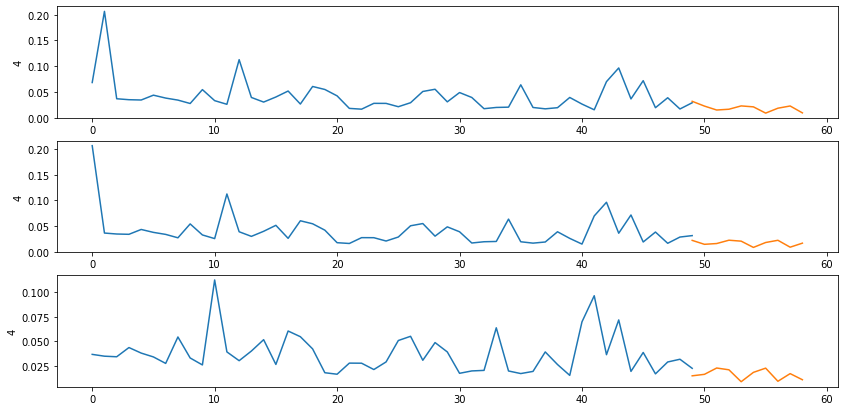

In [43]:
# Set the input_sequence_length length - this is the timeframe used to make a single prediction
input_sequence_length = 50
# The output sequence length is the number of steps that the neural network predicts
output_sequence_length = 10 #

# Prediction Index
index_Close = df_train.columns.get_loc("Close")

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_length = math.ceil(np_scaled.shape[0] * 0.8)

# Create the training and test data
train_data = np_scaled[0:train_data_length, :]
test_data = np_scaled[train_data_length - input_sequence_length:, :]

# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, input_sequence_length time steps per sample, and f features
def partition_dataset(input_sequence_length, output_sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(input_sequence_length, data_len - output_sequence_length):
        x.append(data[i-input_sequence_length:i,:]) #contains input_sequence_length values 0-input_sequence_length * columns
        y.append(data[i:i + output_sequence_length, index_Close]) #contains the prediction values for validation (3rd column = Close),  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(input_sequence_length, output_sequence_length, train_data)
x_test, y_test = partition_dataset(input_sequence_length, output_sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
nrows = 3 # number of shifted plots
fig, ax = plt.subplots(nrows=nrows, ncols=1, figsize=(14, 7))
for i in range(nrows):
    sns.lineplot(y = pd.DataFrame(x_train[i])[index_Close], x = range(input_sequence_length), ax = ax[i])
    sns.lineplot(y = y_train[i], x = range(input_sequence_length -1, input_sequence_length + output_sequence_length - 1), ax = ax[i])
plt.show

Model Training 

In [44]:
# Configure the neural network model
model = Sequential()
n_output_neurons = output_sequence_length

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_input_neurons = x_train.shape[1] * x_train.shape[2]
print(n_input_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_input_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_input_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(n_output_neurons))

# Compile the model
model.compile(optimizer='adam', loss='mse')

250 50 5


In [45]:
# Training the model
epochs = 100
batch_size = 32
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test)
                   )
                    
                    #callbacks=[early_stop])

Epoch 1/100
2191/2191 [==============================] - 33s 13ms/step - loss: 8.7096e-04 - val_loss: 4.3942e-04
Epoch 2/100
2191/2191 [==============================] - 28s 13ms/step - loss: 8.2711e-04 - val_loss: 4.4726e-04
Epoch 3/100
2191/2191 [==============================] - 28s 13ms/step - loss: 8.2266e-04 - val_loss: 4.0014e-04
Epoch 4/100
2191/2191 [==============================] - 28s 13ms/step - loss: 8.1859e-04 - val_loss: 4.2224e-04
Epoch 5/100
2191/2191 [==============================] - 28s 13ms/step - loss: 8.1476e-04 - val_loss: 4.5197e-04
Epoch 6/100
2191/2191 [==============================] - 28s 13ms/step - loss: 8.1553e-04 - val_loss: 4.0047e-04
Epoch 7/100
2191/2191 [==============================] - 28s 13ms/step - loss: 8.1382e-04 - val_loss: 4.0238e-04
Epoch 8/100
2191/2191 [==============================] - 28s 13ms/step - loss: 8.1225e-04 - val_loss: 3.9612e-04
Epoch 9/100
2191/2191 [==============================] - 28s 13ms/step - loss: 8.1093e-04 - val_

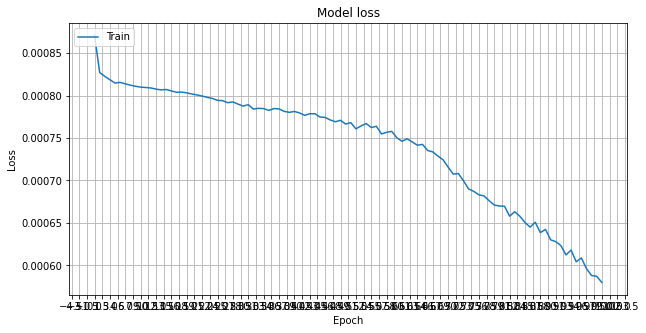

In [46]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(10, 5), sharex=True)
plt.plot(history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

Model Performance Evaluation    

In [47]:
model.save('Model_3MIN_JUN2021_DEC2021.h5')

In [48]:
# Get the predicted values
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test).reshape(-1, output_sequence_length)
y_test_unscaled.shape

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

Median Absolute Error (MAE): 418.6
Mean Absolute Percentage Error (MAPE): 1.36 %
Median Absolute Percentage Error (MDAPE): 0.93 %


Multi Test Forecast

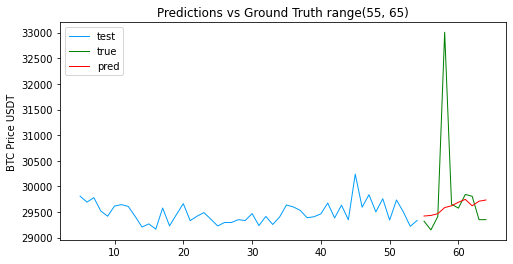

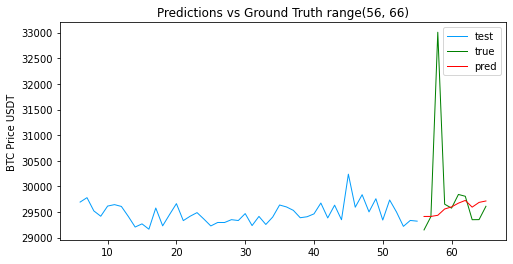

In [49]:
def plot_multi_test_forecast(i, s, x_test, y_test_unscaled, y_pred_unscaled): 
    
    # reshape the testset into a one-dimensional array, so that it fits to the pred scaler
    x_test_scaled_reshaped = np.array(pd.DataFrame(x_test[i])[index_Close]).reshape(-1, 1)
    
    # undo the scaling on the testset
    df_test = pd.DataFrame(scaler_pred.inverse_transform(x_test_scaled_reshaped) )

    # set the max index 
    test_max_index = df_test.shape[0]
    pred_max_index = y_pred_unscaled[0].shape[0]
    test_index = range(i, i + test_max_index)
    pred_index = range(i + test_max_index, i + test_max_index + pred_max_index)
    
    # package y_pred_unscaled and y_test_unscaled into a dataframe with columns pred and true
    data = pd.DataFrame(list(zip(y_pred_unscaled[s], y_test_unscaled[i])), columns=['pred', 'true']) #
    
    fig, ax = plt.subplots(figsize=(8, 4))
    plt.title(f"Predictions vs Ground Truth {pred_index}", fontsize=12)
    ax.set(ylabel =  "BTC Price USDT")
    
    sns.lineplot(data = df_test,  y = df_test[0], x=test_index, color="#039dfc", linewidth=1.0, label='test')
    sns.lineplot(data = data,  y='true', x=pred_index, color="g", linewidth=1.0, label='true')
    sns.lineplot(data = data,  y='pred', x=pred_index, color="r", linewidth=1.0, label='pred')

x_test_unscaled = scaler_pred.inverse_transform(np.array(pd.DataFrame(x_test[0])[index_Close]).reshape(-1, 1)) 
df_test = pd.DataFrame(x_test_unscaled)
    
for i in range(5, 7): #i is the starting point for the batch in the time-series
    #data = pd.DataFrame(list(zip(y_pred[i], y_test_unscaled[i])), columns=['pred', 'true'], index=range(55,65))
    plot_multi_test_forecast(i, i, x_test, y_test_unscaled, y_pred)

New Forecast 

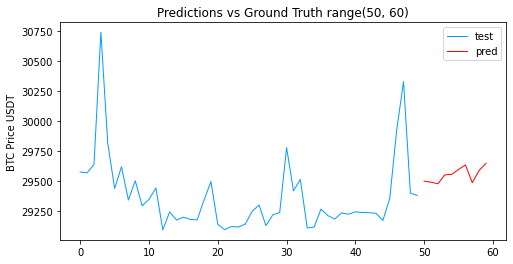

In [50]:
def plot_new_multi_forecast(i_test, i_pred, x_test, y_pred_unscaled): 
    
    # reshape the testset into a one-dimensional array, so that it fits to the pred scaler
    x_test_scaled_reshaped = np.array(pd.DataFrame(x_test[i_test])[index_Close]).reshape(-1, 1)
    
    # undo the scaling on the testset
    df_test = pd.DataFrame(scaler_pred.inverse_transform(x_test_scaled_reshaped) )

    # set the max index 
    test_max_index = df_test.shape[0]
    pred_max_index = y_pred_unscaled[0].shape[0]
    test_index = range(i_test, i_test + test_max_index)
    pred_index = range(i_test + test_max_index, i_test + test_max_index + pred_max_index)
    
    data = pd.DataFrame(list(zip(y_pred_unscaled[i_pred])), columns=['pred']) #
    
    fig, ax = plt.subplots(figsize=(8, 4))
    plt.title(f"Predictions vs Ground Truth {pred_index}", fontsize=12)
    ax.set(ylabel =  "BTC Price USDT")
    
    sns.lineplot(data = df_test,  y = df_test[0], x=test_index, color="#039dfc", linewidth=1.0, label='test')
    sns.lineplot(data = data,  y='pred', x=pred_index, color="r", linewidth=1.0, label='pred')
    
# get the highest index from the x_test dataset
index_max = x_test.shape[0]
x_test_new = np_scaled[-51:-1,:].reshape(1,50,5)

# undo the scaling of the predictions
y_pred_scaled = model.predict(x_test_new)
y_pred = scaler_pred.inverse_transform(y_pred_scaled)

# plot the predictions
plot_new_multi_forecast(0, 0, x_test_new, y_pred)

In [52]:
#Actual Prediction

def prediction(crypto):
  #Choose between BTCUSDT ETHUSDT XMRUSDT

  #Fetch Last Day 1HR Candles Data
  klines = client.get_historical_klines(crypto, Client.KLINE_INTERVAL_1HOUR, "1 day ago UTC")

  pred_df = pd.DataFrame(klines)
  pred_df.columns = (['Open Time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close Time', 'Quote Asset Volume','Nb of Trade', 'TakerBuyBaseVolume', 'TakerBuyQuoteVolume','Ignored'])
  # hist_df.drop(labels = ['TakerBuyBaseVolume', 'TakerBuyQuoteVolume', 'Ignored', 'Quote Asset Volume'], inplace = True,axis = 1)
  pred_df['Close Time'] = pd.to_datetime(pred_df['Close Time']/1000, unit='s')
  # hist_df['Open Time'] = pd.to_datetime(hist_df['Open Time']/1000, unit='s')
  pred_df.drop(['Ignored', 'TakerBuyBaseVolume', 'TakerBuyQuoteVolume', 'Quote Asset Volume'], inplace= True, axis = 1)
  # hist_df['Open Time'] = hist_df.index

  # hist_df = hist_df.reset_index().set_index('Open Time', drop=False)
  # hist_df.index.name = None

  pred_df = pred_df.apply(pd.to_numeric)
  pred = np_scaled[-51:-1,:].reshape(1,50,5)

  # pred_df.to_csv('5H_avg_pred_df')
  # pred_df

  y_pred_scaled = model.predict(pred)
  y_pred = scaler_pred.inverse_transform(y_pred_scaled)

  print(y_pred)

prediction("BTCUSDT")


[[29498.697 29489.803 29476.67  29551.21  29555.6   29596.059 29634.236
  29485.799 29589.375 29647.781]]
